# 順序尺度の相関係数

アンケート調査の「1: あてはまらない」「2: どちらともいえない」「3: あてはまる」のような3値をとる順序尺度の変数や、「該当する」「該当しない」のような二値変数のような、値の種類数が比較的少ない順序尺度の相関係数は、ピアソンの積率相関係数で測った場合過小評価される（絶対値が小さくなる傾向がある）。これは**相関係数の希薄化**と呼ばれる現象である。


:::{hint}
「5値以上あれば積率相関係数でも誤差があまり大きくないため、連続尺度の変数のように積率相関係数にもとづいて相関を分析してもよい」という研究結果もある。

「1: 全くあてはまらない」「2: あまりあてはまらない」...「5: よくあてはまる」の5件法がよく使われる理由のひとつはこのため。

（[萩生田 & 繁桝 1996](https://www.jstage.jst.go.jp/article/jjpsy1926/67/1/67_1_1/_article/-char/ja/)）
:::


こうした問題に対処するために、次のような相関係数が存在する。

- **ポリコリック相関係数**（polychoric correlation coefficient）：順序尺度同士の相関係数
- **ポリシリアル相関係数**（polyserial correlation coefficient）：順序尺度と連続尺度の相関係数



:::{admonition} 順序尺度の相関係数
:class: info

順序尺度についての相関係数は色々ある

- **ポリコリック相関係数（polychoric correlation coefficient、多分相関係数）**
    - 順序尺度 × 順序尺度の変数間の潜在的な連続正規変数に基づく相関係数（2変量正規分布仮定）
- **ポリシリアル相関係数（polyserial correlation coefficient、多分系列相関係数）**
    - 順序尺度 × 連続尺度の変数間の潜在変数モデルに基づく相関係数（順序側が閾値で2値化された連続変数と仮定）
- **テトラコリック相関係数（tetrachoric correlation coefficient、四分相関係数）** 
    - 2値変数 × 2値変数の相関。ただし両者は潜在連続変数をしきい値で2値化したものと仮定（2変量正規分布）
- **バイシリアル相関係数（biserial correlation coefficient、双列相関係数）**
    - 連続変数 × 人工的に2値化された変数の相関（連続データを2値に変換した前提）
- **ポイント・バイシリアル相関係数（point-biserial correlation coefficient、点双列相関係数）**
    - 連続変数 × 真のカテゴリとしての2値変数の相関（2値が自然なカテゴリであり、人工的でない場合）
- **スピアマンの順位相関係数（Spearman's rho）**
    - 順序尺度 × 順序尺度 あるいは 任意の変数を順位に置き換えて測る相関（順位ベースのピアソン相関）
- **ケンドールの順位相関係数（Kendall's tau）**
    - 順序尺度 × 順序尺度に対して使われる相関指標で、順位の一致/不一致ペア数に基づいて計算される

:::

## 例

以下のようなデータがあるとする

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from scipy.stats import multivariate_normal, pearsonr
from semopy.model import hetcor

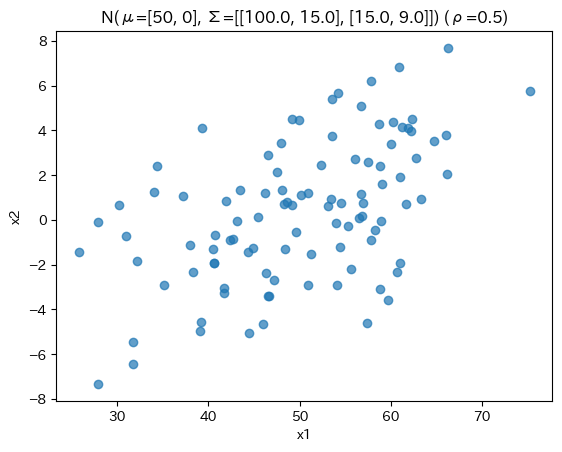

In [2]:
# generate data
n = 100
mean = [50, 0]
std = [10, 3]
rho = 0.5
cov = rho * std[0] * std[1]
Cov = np.array([
    [std[0]**2, cov],
    [cov, std[1]**2]
])

X = multivariate_normal.rvs(mean=mean, cov=Cov, size=n, random_state=0)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], alpha=.7)
ax.set(xlabel="x1", ylabel="x2", title=f"N(μ={mean}, Σ={Cov.tolist()}) (ρ={rho})")
fig.show()

適当な閾値で区切って離散化したとする。

In [3]:
# 離散化
d1 = X[:, 0] >= X[:, 0].mean()
d2 = np.ones(shape=(n, ))
d2[(-4 <= X[:, 1]) & (X[:, 1] < 4)] = 2
d2[(4 <= X[:, 1])] = 3

D = np.array([d1, d2]).T
D = pd.DataFrame(D, columns=["d1", "d2"]).astype(int)

table = pd.crosstab(D["d1"], D["d2"])
print("離散化したデータのクロス集計表")
table #.style.set_caption("クロス集計表")

離散化したデータのクロス集計表


d2,1,2,3
d1,,,
0,7,39,2
1,1,38,13


離散化前の量的変数に積率相関係数を適用した場合と、離散化後の質的変数に積率相関係数を使用した場合、そしてポリコリック相関係数を使用した場合の結果は次のようになる。

In [4]:
from semopy.polycorr import polychoric_corr

pd.DataFrame([
    dict(method="積率相関係数を量的変数に適用", value=pearsonr(X[:, 0], X[:, 1]).statistic),
    dict(method="積率相関係数を質的変数に適用", value=D.corr().iloc[0, 1]),
    dict(method="ポリコリック相関係数を質的変数に適用", value=polychoric_corr(D["d1"], D["d2"]))
]).style.format({"value": "{:.3f}"})

,method,value
0,積率相関係数を量的変数に適用,0.517
1,積率相関係数を質的変数に適用,0.353
2,ポリコリック相関係数を質的変数に適用,0.570


質的変数にピアソンの積率相関係数を使用すると、相関が過小評価されていること、そしてポリコリック相関係数のほうが離散化前の相関係数の再現度がより高いことがわかる。

## カテゴリの値がいくつだと積率相関係数でもよいか

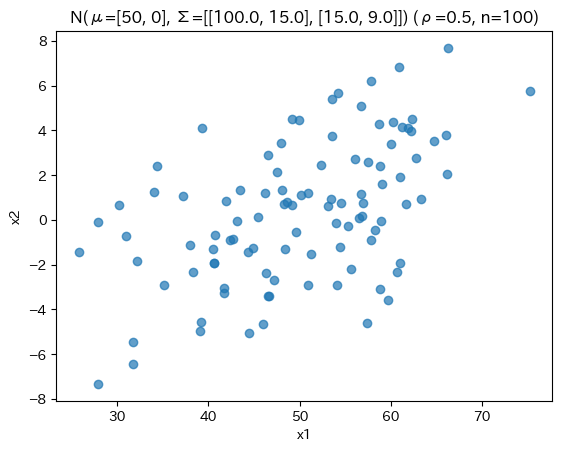

In [5]:
# generate data
n = 100
mean = [50, 0]
std = [10, 3]
rho = 0.5
cov = rho * std[0] * std[1]
Cov = np.array([
    [std[0]**2, cov],
    [cov, std[1]**2]
])

X = multivariate_normal.rvs(mean=mean, cov=Cov, size=n, random_state=0)
X = pd.DataFrame(X)

fig, ax = plt.subplots()
ax.scatter(X[0], X[1], alpha=.7)
ax.set(xlabel="x1", ylabel="x2", title=f"N(μ={mean}, Σ={Cov.tolist()}) (ρ={rho}, n={n})")
fig.show()

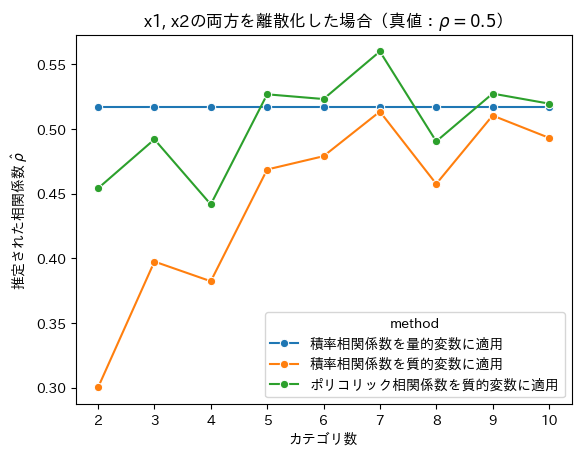

In [6]:
results = []
for k in range(2, 11):
    d1 = pd.cut(X[0], bins=k, labels=range(k)).astype(int)
    d2 = pd.cut(X[1], bins=k, labels=range(k)).astype(int)

    result = [
        dict(method="積率相関係数を量的変数に適用", value=pearsonr(X[0], X[1]).statistic, k=k),
        dict(method="積率相関係数を質的変数に適用", value=pearsonr(d1, d2).statistic, k=k),
        dict(method="ポリコリック相関係数を質的変数に適用", value=polychoric_corr(d1, d2), k=k)
    ]
    results += result
results = pd.DataFrame(results)

import seaborn as sns
sns.lineplot(x="k", y="value", data=results, hue="method", marker="o")
plt.xlabel("カテゴリ数")
plt.ylabel(r"推定された相関係数 $\hat{\rho}$")
plt.title(r"x1, x2の両方を離散化した場合（真値：$\rho = 0.5$）")
plt.show()

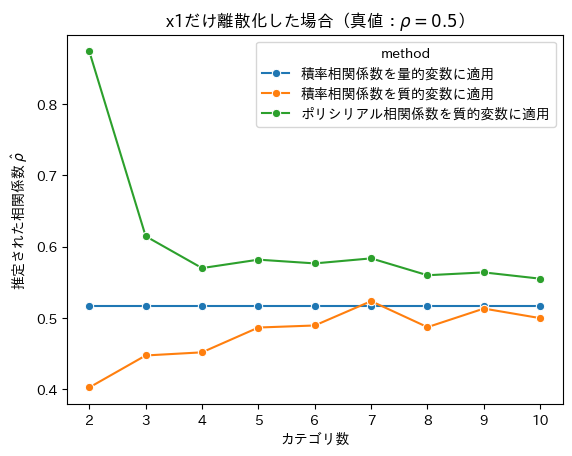

In [7]:
from semopy.polycorr import polyserial_corr

results = []
for k in range(2, 11):
    d1 = pd.cut(X[0], bins=k, labels=range(k)).astype(int)

    result = [
        dict(method="積率相関係数を量的変数に適用", value=pearsonr(X[0], X[1]).statistic, k=k),
        dict(method="積率相関係数を質的変数に適用", value=pearsonr(d1, X[1]).statistic, k=k),
        dict(method="ポリシリアル相関係数を質的変数に適用", value=polyserial_corr(X[1], d1), k=k)
    ]
    results += result
results = pd.DataFrame(results)

import seaborn as sns
sns.lineplot(x="k", y="value", data=results, hue="method", marker="o")
plt.xlabel("カテゴリ数")
plt.ylabel(r"推定された相関係数 $\hat{\rho}$")
plt.title(r"x1だけ離散化した場合（真値：$\rho = 0.5$）")
plt.show()

## 順序尺度の相関係数はどういうふうに推定するのか

基本的な考え方としては、「離散値の背景には何らかの連続尺度が潜在的に存在する」という仮定をおくものである。

例えばアンケート調査なら、その潜在的な連続変数が一定のしきい値以上になった場合に「よくあてはまる」といった回答がなされている、と考える。



## テトラコリック相関係数（tetrachoric correlation）

**テトラコリック相関係数** （tetrachoric correlation coefficient, **四分相関係数** とも） は、二値変数同士の相関係数で、2つの二値変数の背後に連続変数が存在すると仮定して、それらの間の相関の強さを推定する。

:::{card} 関連文献

- [Pearson, K. (1900). Mathematical contributions to the theory of evolution.—VII. On the correlation of characters not quantitatively measurable. Philosophical Transactions of the Royal Society of London. Series A, Containing Papers of a Mathematical or Physical Character, 195(262-273), 1-47.](https://royalsocietypublishing.org/doi/10.1098/rsta.1900.0022)
- [Hamdan, M. A. (1970). The equivalence of tetrachoric and maximum likelihood estimates of P in 2× 2 tables.](https://www.jstor.org/stable/2334955)
- [Brown, M. B., & Benedetti, J. K. (1977). On the mean and variance of the tetrachoric correlation coefficient. Psychometrika, 42(3), 347-355.](https://www.cambridge.org/core/journals/psychometrika/article/abs/on-the-mean-and-variance-of-the-tetrachoric-correlation-coefficient/029C2190E6A9B8D40EB7D2924112E2A4)
- [Everitt, P. F. (1910). Tables of the tetrachoric functions for fourfold correlation tables. Biometrika, 7(4), 437-451.](https://www.jstor.org/stable/2345377?origin=JSTOR-pdf)
- [Castellan Jr, N. J. (1966). On the estimation of the tetrachoric correlation coefficient. Psychometrika, 31(1), 67-73.](https://www.cambridge.org/core/journals/psychometrika/article/abs/on-the-estimation-of-the-tetrachoric-correlation-coefficient/60F0218237B83F1B00B93234B8B354FC)

:::

:::{dropdown} 歴史的経緯 （from [Olsson (1979)](https://www.cambridge.org/core/journals/psychometrika/article/abs/maximum-likelihood-estimation-of-the-polychoric-correlation-coefficient/62B8AC8F4B0EC5ED7F5B5037A9EAC40D)）

Pearson (1901) で標準正規分布の累積分布

$$
\Phi(\tau_X, \tau_Y ; \rho)=\frac{1}{2 \pi\sqrt{1-\rho^2}}
\int_{-\infty}^{\tau_X} \int_{-\infty}^{\tau_Y} \exp \left[-\frac{x^2-2 \rho x y+y^2}{2\left(1-\rho^2\right)}\right] d x d y
$$

から$\rho$を解くことで求める方法が提案された。

[Hamdan (1970)](https://www.jstor.org/stable/2334955) は2x2表から$\rho$を最尤推定することとtetrachoric correlationが等しいことを示した。

[Brown & Benedetti (1977)](https://www.cambridge.org/core/journals/psychometrika/article/abs/on-the-mean-and-variance-of-the-tetrachoric-correlation-coefficient/029C2190E6A9B8D40EB7D2924112E2A4) はtetrachoric correlationが対応する真の相関に対してバイアスがあるが、セルの予想される頻度が5未満でない場合、バイアスは無視できることを示した。

:::

### 推定方法

2つの観測変数$X, Y \in \{0, 1\}$があるとし、その背後に正規分布に従う潜在変数$X^*, Y^*$

$$
\left(X^*, Y^*\right) \sim \mathcal{N}\left(\left[\begin{array}{l}
0 \\
0
\end{array}\right],\left[\begin{array}{ll}
1 & \rho \\
\rho & 1
\end{array}\right]\right)
$$

があり、それぞれの潜在変数がある閾値によって二値に変換されている、すなわち

$$
X = \mathbb{1}( X^* > \tau_{X}), \quad
Y = \mathbb{1}( Y^* > \tau_{Y})
$$

とする。

相関係数$\rho$ と 2変量の標準正規分布の累積分布関数$\Phi_2(\tau_i, \tau_j; \rho)$ による同時確率

$$
P(X=i, Y=j) = \Phi_2(\tau_i, \tau_j; \rho)
$$

を考えて、ここから尤度関数を作って最尤推定を行う。

観測値のクロス集計表を以下のように計算したとする。

|       |  $Y=0$   |  $Y=1$   | 合計  |
| :---: | :------: | :------: | :---- |
| $X=0$ | $n_{00}$ | $n_{01}$ | $n_0$ |
| $X=1$ | $n_{10}$ | $n_{11}$ | $n_1$ |
| 合計  | $n_{.0}$ | $n_{.1}$ | $n$   |


仮定

$$
\begin{aligned}
& X=1 \Leftrightarrow X^*>\tau_X \\
& Y=1 \Leftrightarrow Y^*>\tau_Y
\end{aligned}
$$

により、

$$
\begin{aligned}
& X=0 \Leftrightarrow X^* \leq \tau_X \\
& Y=0 \Leftrightarrow Y^* \leq \tau_Y
\end{aligned}
$$

なので、標準正規分布の分位点関数$\Phi^{-1}$を使うと

$$
\begin{gathered}
\tau_X=\Phi^{-1}(P(X=0))=\Phi^{-1}\left(\frac{n_{00}+n_{01}}{n}\right) \\
\tau_Y=\Phi^{-1}(P(Y=0))=\Phi^{-1}\left(\frac{n_{00}+n_{10}}{n}\right)
\end{gathered}
$$

:::{margin}

標準正規分布の累積分布関数（CDF）を $\Phi(z)$ とすると ：

$$
\Phi(z)=P(Z \leq z) \quad \text { where } Z \sim \mathcal{N}(0,1)
$$


その逆関数が $\Phi^{-1}(p)$、つまり：

$$
\Phi^{-1}(p)=z \quad \text { such that } \Phi(z)=p
$$


:::

$P_{ij} = P(X=i, Y=j)$とすると

$$
\begin{aligned}
& P_{00}=\Phi_2\left(\tau_X, \tau_Y ; \rho\right) \\
& P_{01}=\Phi\left(\tau_X\right)-\Phi_2\left(\tau_X, \tau_Y ; \rho\right) \\
& P_{10}=\Phi\left(\tau_Y\right)-\Phi_2\left(\tau_X, \tau_Y ; \rho\right) \\
& P_{11}=1-\Phi\left(\tau_X\right)-\Phi\left(\tau_Y\right)+\Phi_2\left(\tau_X, \tau_Y ; \rho\right)
\end{aligned}
$$


ここで：
-  $\boldsymbol{\Phi}:$ 標準正規分布のCDF
- $\Phi_2(u, v ; \rho): 2$ 変量正規分布のCDF（平均0、分散1、相関 $\rho$）

そして次の対数尤度を最大化して推定する

$$
\log L(\rho)=n_{00} \log P_{00}+n_{01} \log P_{01}+n_{10} \log P_{10}+n_{11} \log P_{11}
$$

In [29]:
from scipy.optimize import minimize_scalar

def tetrachoric_corr(x: np.ndarray, y: np.ndarray) -> float:
    n = len(x)
    n00 = np.sum((x == 0) & (y == 0))
    n01 = np.sum((x == 0) & (y == 1))
    n10 = np.sum((x == 1) & (y == 0))
    n11 = np.sum((x == 1) & (y == 1))
    
    px0 = (n00 + n01) / n
    py0 = (n00 + n10) / n
    
    tau_x = norm.ppf(px0)
    tau_y = norm.ppf(py0)

    def neg_log_likelihood(rho):
        cov = np.array([[1, rho], [rho, 1]])
        p00 = multivariate_normal.cdf([tau_x, tau_y], mean=[0, 0], cov=cov)
        p01 = norm.cdf(tau_x) - p00
        p10 = norm.cdf(tau_y) - p00
        p11 = 1 - norm.cdf(tau_x) - norm.cdf(tau_y) + p00

        probs = np.array([p00, p01, p10, p11])
        counts = np.array([n00, n01, n10, n11])

        assert np.all(probs >= 0)
        return -np.sum(counts * np.log(probs))

    result = minimize_scalar(neg_log_likelihood, bounds=(-0.999, 0.999), method='bounded')
    return result.x

In [30]:
# データ生成（潜在相関0.6）
np.random.seed(1)
latent_x = np.random.normal(size=100)
latent_y = 0.6 * latent_x + np.random.normal(size=100)
X = (latent_x > 0.3).astype(int)
Y = (latent_y > 0.3).astype(int)

# 推定
rho_hat = tetrachoric_corr(X, Y)
print(f"推定されたテトラコリック相関: {rho_hat:.4f}")

推定されたテトラコリック相関: 0.4084


## ポリコリック相関係数

**ポリコリック相関係数**（polychoric correlation coefficient, **多分相関係数** とも）は順序尺度の変数同士での相関関係を測る係数。


### 推定方法

[小杉考司（2013）](http://kosugitti.sakura.ne.jp/wp/wp-content/uploads/2013/08/polynote.pdf)を参考に、二段階の最尤推定を行う方法を紹介する。

まず、観測された順序尺度の変数の背景に連続尺度の変数が存在し、それらは二変量の標準正規分布に従うと仮定する。
2変量正規分布の空間を閾値で区切って離散化されたものが観測値として実現したと考える。

### 尤度関数

クロス集計表におけるセル$(i, j)$の観測度数を$n_{ij}$とする（$i=1,2,\cdots, s, \ j=1,2,\cdots,r$）。

観測度数がセル$(i, j)$に含まれる確率を$\pi_{ij}$とすれば、そのサンプルの尤度は

$$
L = C \prod^s_{i=1} \prod^r_{j=1} \pi_{ij}^{n_{ij}}
$$

である。ここで$C$は定数で、最尤推定においては推定に関わらないので気にしなくてよい。対数尤度は

$$
\ell = \ln L = \ln C + \sum^s_{i=1} \sum^r_{j=1} n_{ij} \ln \pi_{ij}
$$


相関を測りたい変数が$x,y$の2つあるとし、変数$x$の閾値を$a_i$、変数$y$の閾値を$b_j$と表す（$i=0, 1,2,\cdots, s, \ j=0,1,2,\cdots,r$）。
ここで$a_0 = b_0 = -\infty, a_s = b_r = +\infty$である。

$\pi_{ij}$は相関係数$\rho$の2変数正規分布$\Phi_2$を用いて

$$
\pi_{ij} = \Phi_2(a_i, b_j)
- \Phi_2(a_{i-1}, b_j)
- \Phi_2(a_i, b_{j-1})
+ \Phi_2(a_{i-1}, b_{j-1})
$$

と表すことができる。

### 推定

閾値は次のように推定することができる。

$$
\begin{aligned}
a_i = \Phi_1^{-1}(P_{i \cdot})\\
b_j = \Phi_1^{-1}(P_{\cdot j})
\end{aligned}
$$

ここで$P_{i \cdot}, P_{\cdot j}$は観測された累積周辺分布である。


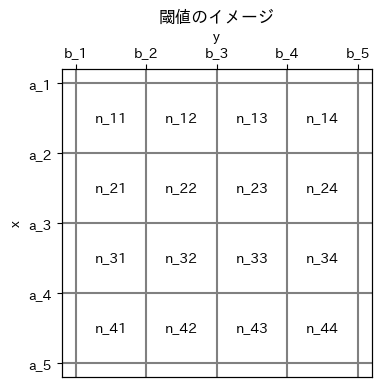

In [8]:
fig, ax1 = plt.subplots(figsize=[4, 4])

k = 5
ticks = range(0, 2 * k, 2)
ticklabels_a = [f"a_{i}" for i in range(1, k + 1)]
ticklabels_b = [f"b_{i}" for i in range(1, k + 1)]

for tick in ticks:
    ax1.axhline(tick, color="gray")
    ax1.axvline(tick, color="gray")

cell_coords = range(1, 2 * k - 1, 2)
for i_show, i in enumerate(cell_coords, start=1):
    for j_show, j in enumerate(cell_coords, start=1):
        ax1.text(j, i, f"n_{i_show}{j_show}", ha="center", va="center")

ax1.set(ylabel="x", xticks=[], title="閾値のイメージ")
ax1.set_yticks(ticks=ticks, labels=ticklabels_a)
ax1.invert_yaxis()

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("y")
ax2.set_xticks(ticks=ticks, labels=ticklabels_b)
fig.show()

### 推定の流れ

実際に推定してみよう。

まずクロス集計表を作って観測度数を得る。

In [9]:
table = pd.crosstab(D["d1"], D["d2"])
table

d2,1,2,3
d1,,,
0,7,39,2
1,1,38,13


クロス集計表を横軸や縦軸に向けて合計していき、累積周辺分布$P_{i \cdot}, P_{\cdot j}$を得る


In [10]:
# 累積周辺分布
n = table.sum().sum()
Pi = table.sum(axis=1).cumsum().to_list() / n
Pj = table.sum(axis=0).cumsum().to_list() / n
print(f"{Pi=} {Pj=}")

Pi=array([0.48, 1.  ]) Pj=array([0.08, 0.85, 1.  ])


$a_i, b_j$を推定する。$a_0 = b_0 = -\infty$、$a_s = b_r = \infty$となるようにする

In [11]:
# 閾値a, bを推定
from scipy.stats import norm
a = norm.ppf(Pi, loc=0, scale=1)
b = norm.ppf(Pj, loc=0, scale=1)

# 簡単のためnp.infを使うが本格的に使う場合は大きな値（10とか100とか）をinfの代わりに使うと尤度が不連続になりづらかった
a = [-np.inf, *a]
b = [-np.inf, *b]

print(f"{a=}")
print(f"{b=}")

a=[-inf, -0.05015358346473367, inf]
b=[-inf, -1.4050715603096329, 1.0364333894937898, inf]


確率密度

$$
\pi_{ij} = \Phi_2(a_i, b_j)
- \Phi_2(a_{i-1}, b_j)
- \Phi_2(a_i, b_{j-1})
+ \Phi_2(a_{i-1}, b_{j-1})
$$

の推定と、対数尤度

$$
\ln L = \ln C + \sum^s_{i=1} \sum^r_{j=1} n_{ij} \ln \pi_{ij}
$$

の計算を行う関数を作る

In [12]:
from scipy.stats import multivariate_normal

def log_likelihood(rho, a=a, b=b, table=table):
    Cov = np.array([
        [1, rho],
        [rho, 1]
    ])
    n = np.array(table)
    likelihood = 0
    for i in range(1, len(a)):
        for j in range(1, len(b)):
            ij = multivariate_normal.cdf([a[i], b[j]], mean=[0, 0], cov=Cov)
            ij = 0 if np.isnan(ij) else ij

            i1j = multivariate_normal.cdf([a[i-1], b[j]], mean=[0, 0], cov=Cov)
            i1j = 0 if np.isnan(i1j) else i1j

            ij1 = multivariate_normal.cdf([a[i], b[j-1]], mean=[0, 0], cov=Cov)
            ij1 = 0 if np.isnan(ij1) else ij1

            i1j1 = multivariate_normal.cdf([a[i-1], b[j-1]], mean=[0, 0], cov=Cov)
            i1j1 = 0 if np.isnan(i1j1) else i1j1
            pi = ij - i1j - ij1 + i1j1
            # ちなみにpiの推定は上記のように愚直にやらずとも scipy.stats の mvn.mvnun でもできる

            if pi > 0:
                likelihood += n[i-1, j-1] * np.log(pi)
    return likelihood

log_likelihood(rho=0.1)

-135.95432934194218

尤度を最大にする$\rho$を探索する。

今回は$\rho$が$(-1, 1)$にあることがわかっているので、その範囲を細かく刻んで全部計算して最良の$\rho$を推定値とする、という全探索法をつかうこともできる。

この方法を実際に行ったのが次の図である。

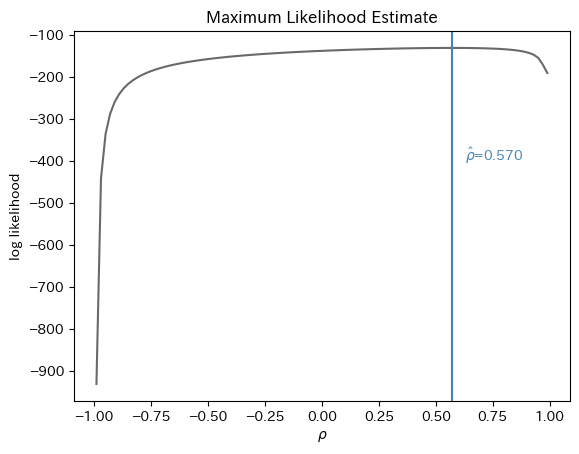

In [13]:
# 最尤推定1: 全探索
rho_range = np.linspace(-0.99, 0.99, 100)
likelihoods = np.array([log_likelihood(rho) for rho in rho_range])
rho_hat = rho_range[np.argmax(likelihoods)]

fig, ax = plt.subplots()
ax.plot(rho_range, likelihoods, color="dimgray")
ax.set(xlabel=r"$\rho$", ylabel="log likelihood", title="Maximum Likelihood Estimate")

l = likelihoods[~np.isinf(likelihoods)]
y = -(l.max() - l.min()) / 2
ax.text(rho_hat * 1.1, y, r"$\hat{\rho}$"+f"={rho_hat:.3f}", color="steelblue")
ax.axvline(rho_hat, color="steelblue")

fig.show()

`scipy.optimize.fminbound`などを使ってBrent法という最適化手法を用いると効率的である。

（実際、`semopy`や`RyStats`などのパッケージではscipyの最適化関数を呼び出すことでBrent法を使っている: [semopy/polycorr.py](https://gitlab.com/georgy.m/semopy/-/blob/master/semopy/polycorr.py)）

In [14]:
# ※minimizeの関数に入れるために負の対数尤度にしている
from scipy.optimize import fminbound
fminbound(lambda rho: -log_likelihood(rho), -0.999, 0.999)

0.5697450392309811

### ポリコリック相関係数の考え方まとめ

2つの順序尺度変数 $X, Y$ があるとし、それぞれ次のように閾値で切って離散化されたと仮定する

$$
\begin{array}{lll}
X=i & \text { if } & \tau_{X, i-1}<X^* \leq \tau_{X, i} \\
Y=j & \text { if } & \tau_{Y, j-1}<Y^* \leq \tau_{Y, j}
\end{array}
$$

ここで

- $X^*, Y^*$ ：潜在的な連続変数
- $\tau_{X, i}, \tau_{Y, j}$ ：それぞれのカデコリに対応するしきい値
- $\left(X^*, Y^*\right) \sim N_2(0,0,1,1, \rho)$ ：平均0、分散 1、相関 $\rho$ の2変量正規分布に従うと仮定

である。

$X, Y$のクロス集計を考えると、観測セル$(i,j)$の確率は、2変量正規分布の累積分布$\Phi_2$で表される

$$
P_{i j} = \operatorname{Pr}(X=i, Y=j)
= \Phi_2\left(\tau_{X, i}, \tau_{Y, j} ; \rho\right)
-\Phi_2\left(\tau_{X, i-1}, \tau_{Y, j} ; \rho\right)
-\Phi_2\left(\tau_{X, i}, \tau_{Y, j-1} ; \rho\right)
+\Phi_2\left(\tau_{X, i-1}, \tau_{Y, j-1} ; \rho\right)
$$

ここで $\Phi_2(a, b; \rho)$ は 平均0・分散1・相関 $\rho$ の2変量正規分布の累積分布関数（CDF）である。

:::{margin}

単変量の場合、 $a<b$の半開区間$(a, b]$の確率は

$$
P(a < X \leq b) = F(b) - F(a)
$$

となる。

同様に2変量正規分布では

$$
P(a_X < X \leq b_X, ~ a_Y < Y \leq b_Y)
=\Phi_2(b_X, b_Y)-\Phi_2(a_X, b_Y)-\Phi_2(b_X, a_Y)+\Phi_2(a_X, a_Y)
$$

となる。
:::

観測されたクロス集計表 $\left\{n_{i j}\right\}$ に基づく尤度関数は

$$
\log L\left(\rho,\left\{\tau_X\right\},\left\{\tau_Y\right\}\right) = \sum_i \sum_j n_{i j} \cdot \log \left(P_{i j}\right)
$$

となる。ここで

- $n_{i j}$ ：カテゴリ $(i, j)$ の観測頻度
- $P_{i j}$ ：上記の矩形積分によって計算される理論確率

である。

$P_{ij}$を計算するときに使う閾値$\tau_X, \tau_Y$は単変量の正規分布の累積分布関数$\Phi_1(\cdot)$を使って次のように推定することができる。

$$
\begin{aligned}
\tau_X = \Phi_1^{-1}(P_{i \cdot})\\
\tau_Y = \Phi_1^{-1}(P_{\cdot j})
\end{aligned}
$$

ここで$P_{i \cdot}, P_{\cdot j}$は観測された累積周辺分布である。

$\tau_X, \tau_Y$を観測値から推定することで、最尤推定する対象は$\rho$だけになる

$$
\hat{\rho} = \operatorname*{arg max}_{\rho} \log L (\rho)
$$

:::{card} 関連文献

- [Olsson, U. (1979). Maximum likelihood estimation of the polychoric correlation coefficient. Psychometrika, 44(4), 443-460.](https://www.cambridge.org/core/journals/psychometrika/article/abs/maximum-likelihood-estimation-of-the-polychoric-correlation-coefficient/62B8AC8F4B0EC5ED7F5B5037A9EAC40D)
- Drasgow, F. (1986). Polychoric and polyserial correlations In: Kotz S, Johnson N, editors. The Encyclopedia of Statistics.
    - こっちのほうが数式は簡潔でわかりやすい

:::

In [15]:
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.optimize import minimize_scalar

def polychoric_correlation(x: np.ndarray, y: np.ndarray, inf: float | int = 100) -> float:
    """
    Estimate the polychoric correlation coefficient between two ordinal variables.

    Parameters
    ----------
    x : np.ndarray
        Ordinal variable X (integer-coded).
    y : np.ndarray
        Ordinal variable Y (integer-coded).
    inf : 閾値推定の上限・下限
        理論上は無限を使うが、数値計算上は別の値のほうが安定しやすい。実験用に指定可能にする

    Returns
    -------
    float
        Estimated polychoric correlation coefficient (rho).
    """

    # Step 1: Ensure inputs are numpy arrays and integer-coded
    x = np.asarray(x)
    y = np.asarray(y)

    if not np.issubdtype(x.dtype, np.integer) or not np.issubdtype(y.dtype, np.integer):
        raise ValueError("Inputs x and y must be integer-coded ordinal variables.")

    # Step 2: Identify unique ordinal levels
    x_levels = np.sort(np.unique(x))
    y_levels = np.sort(np.unique(y))

    # Step 3: Estimate thresholds from empirical marginal proportions
    def estimate_thresholds(values, inf):
        thresholds = []
        levels = np.sort(np.unique(values))
        for level in levels[:-1]:  # exclude top category
            p = np.mean(values <= level)
            thresholds.append(norm.ppf(p))  # τ_i = Φ⁻¹(P(X ≤ i))
        return np.concatenate(([-inf], thresholds, [inf]))

    tau_x = estimate_thresholds(x, inf)  # thresholds for X: τ_X
    tau_y = estimate_thresholds(y, inf)  # thresholds for Y: τ_Y

    # Step 4: Construct contingency table n_ij
    contingency = np.zeros((len(tau_x) - 1, len(tau_y) - 1), dtype=int)
    for i, xi in enumerate(x_levels):
        for j, yj in enumerate(y_levels):
            contingency[i, j] = np.sum((x == xi) & (y == yj))  # n_ij

    # Step 5: Define negative log-likelihood function based on P_ij = Φ₂(τ_i, τ_j; ρ)
    def neg_log_likelihood(rho):
        if not (-0.999 < rho < 0.999):
            return np.inf

        cov = np.array([[1, rho],
                        [rho, 1]])
        log_likelihood = 0.0

        for i in range(len(tau_x) - 1):
            for j in range(len(tau_y) - 1):
                lower = [tau_x[i], tau_y[j]]
                upper = [tau_x[i+1], tau_y[j+1]]

                # P_ij = Φ₂(τ_{i}, τ_{j}) - Φ₂(τ_{i-1}, τ_{j}) - Φ₂(τ_{i}, τ_{j-1}) + Φ₂(τ_{i-1}, τ_{j-1})
                p_ij = multivariate_normal.cdf(upper, mean=[0, 0], cov=cov) \
                     - multivariate_normal.cdf([lower[0], upper[1]], mean=[0, 0], cov=cov) \
                     - multivariate_normal.cdf([upper[0], lower[1]], mean=[0, 0], cov=cov) \
                     + multivariate_normal.cdf(lower, mean=[0, 0], cov=cov)

                p_ij = max(p_ij, 1e-10) # soft clipping
                
                if np.isnan(p_ij):
                    continue

                log_likelihood += contingency[i, j] * np.log(p_ij)

        return -log_likelihood  # minimize negative log-likelihood

    # Step 6: Optimize to find MLE for rho
    result = minimize_scalar(neg_log_likelihood, bounds=(-0.999, 0.999), method="bounded")

    # plot for debug
    rho_range = np.linspace(-0.999, 0.999, 200)
    likelihoods = np.array([neg_log_likelihood(rho) for rho in rho_range])
    rho_hat = rho_range[np.argmin(likelihoods)]
    
    fig, ax = plt.subplots(figsize=[4,3])
    ax.plot(rho_range, likelihoods, color="dimgray")
    ax.set(xlabel=r"$\rho$", ylabel="log likelihood", title="Maximum Likelihood Estimate")
    l = likelihoods[~np.isinf(likelihoods)]
    # y = -(l.max() - l.min()) / 2
    y = np.min(likelihoods)
    ax.text(rho_hat * 1.1, y * 1.5, r"$\hat{\rho}$"+f"={rho_hat:.3f}", color="steelblue")
    ax.axvline(rho_hat, color="steelblue")
    fig.show()
    
    return result.x

閾値の推定のとき下限と上限を無限以外の計算可能な値にすると対数尤度関数が不連続なジャンプをしにくい

0.4701461875168032

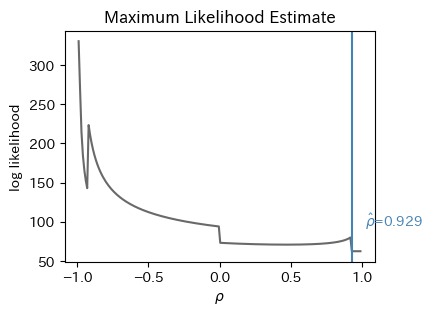

In [16]:
x = D["d1"]
y = D["d2"]
polychoric_correlation(x, y, inf=np.inf)

0.5697450392309811

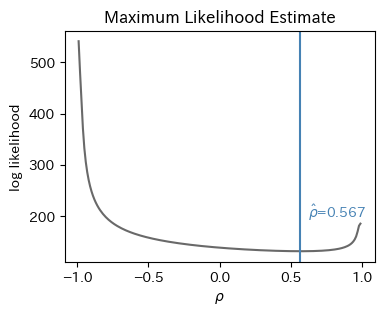

In [17]:
polychoric_correlation(x, y, inf=10)

In [18]:
from semopy.polycorr import polychoric_corr
polychoric_corr(x, y)

0.5697450425585407

## ポリシリアル相関係数

**ポリシリアル相関係数（polyserial correlation）** は順序尺度の変数と連続変数の間の相関係数。


### モデルの仮定

順序尺度の変数$Y$は連続潜在変数$Y^*$をある閾値で分割したものであると仮定する

$$
Y= y_j \quad \text { if } ~ \tau_{j-1}<Y^* \leq \tau_j
, \quad j = 1, 2, \dots, J
$$

ここで

- $Y^*$ ：連続潜在変数。標準正規分布に従う：$\operatorname{E}[Y] = 0, \operatorname{Var}[Y] = 1$
- $X$ ：連続観測変数。$\operatorname{E}[X] = \mu_X, \operatorname{Var}[X] = \sigma_X$
- $(X, Y^*)$ は 2変量正規分布に従うと仮定：

$$
\left[\begin{array}{c}
X \\
Y^*
\end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{l}
\mu_X \\
0
\end{array}\right],\left[\begin{array}{ll}
\sigma_X^2 & \rho \\
\rho & 1
\end{array}\right]\right)
$$


### 尤度関数

$n$個のサンプル$(x_i, y_i)$の尤度関数$L$は、

$$
L = \prod_{i=1}^n f_{XY}(x_i, y_i)
= \prod_{i=1}^n f_{X}(x_i) P(Y=y_i \mid X=x_i)
$$

となる。ここで$f_{XY}, f_{X}$は正規分布の密度関数。


$Y$の$X=x_i$による条件つき分布$P(Y=y_i \mid X=x_i)$は、$x_i$を標準化した$z_i =(x_i - \mu_X) / \sigma_X$を考えると 平均$\rho z_i$、分散$(1- \rho)$の正規分布に従うため

$$
P(Y = y_j \mid X = x_i) = \Phi(\tau_j^*) - \Phi(\tau_{j-1}^*), \quad j = 1, 2, \dots, J
$$

ここで$\tau_j^*$は正規化した閾値（標準正規空間での閾値）

$$
\tau_j^* = \frac{\tau_j-\rho z_i}{\sqrt{1-\rho^2}}
$$

である。


こうして対数尤度関数

$$
\log L(\rho)=\sum_{i=1}^n \log \left[\Phi\left(\frac{\tau_{y_i}-\rho z_i}{\sqrt{1-\rho^2}}\right)-\Phi\left(\frac{\tau_{y_i-1}-\rho z_i}{\sqrt{1-\rho^2}}\right)\right]
$$

を構築できる。

:::{margin} 条件付き分布

2変量正規分布：

$$
\left[\begin{array}{c}
X \\
Y^*
\end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{l}
\mu_X \\
\mu_Y
\end{array}\right],\left[\begin{array}{cc}
\sigma_X^2 & \rho \sigma_X \sigma_Y \\
\rho \sigma_X \sigma_Y & \sigma_Y^2
\end{array}\right]\right)
$$


としたとき，$X=x$ という条件のもとでの $Y^*$ の条件付き分布は ：

$$
Y^* \mid X=x \sim \mathcal{N}\left(
    \mu_{Y \mid X}=\mu_Y+\rho \frac{\sigma_Y}{\sigma_X}\left(x-\mu_X\right), \quad
    \sigma_{Y \mid X}^2=\sigma_Y^2\left(1-\rho^2\right)
\right)
$$

標準正規分布に従う $z_i = (x_i - \mu_X) / \sigma_X$ があるとすれば

$$
Y^* \mid Z = z_i \sim \mathcal{N}\left(\rho z_i, 1-\rho^2\right)
$$

となる
:::

:::{card} 関連文献

- Drasgow, F. (1986). Polychoric and polyserial correlations In: Kotz S, Johnson N, editors. The Encyclopedia of Statistics.

:::

In [19]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar

def normalize_ordinal(x: np.ndarray[int]) -> np.ndarray[int]:
    """Normalize ordinal variable to be integer-coded starting from 0."""
    unique_values = np.unique(x)
    value_to_code = {value: code for code, value in enumerate(unique_values)}
    return np.vectorize(value_to_code.get)(x)

def polyserial_correlation(x: np.ndarray, y: np.ndarray) -> float:
    """
    Estimate the polyserial correlation coefficient between a continuous variable x
    and an ordinal variable y using maximum likelihood estimation.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    if not np.issubdtype(y.dtype, np.integer):
        raise ValueError("y must be an integer-coded ordinal variable.")

    # Standardize x
    z = (x - np.mean(x)) / np.std(x)

    # Estimate thresholds τ from y
    def estimate_thresholds(y):
        levels = np.sort(np.unique(y))
        thresholds = []
        for level in levels[:-1]:  # exclude top category
            p = np.mean(y <= level)
            thresholds.append(norm.ppf(p))
        return np.concatenate(([-np.inf], thresholds, [np.inf]))

    y = normalize_ordinal(y)
    tau = estimate_thresholds(y)

    def neg_log_likelihood(rho):
        log_likelihood = 0.0
        for i in range(len(z)):
            j = y[i]
            tau_lower = (tau[j] - rho * z[i]) / np.sqrt(1 - rho**2)
            tau_upper = (tau[j + 1] - rho * z[i]) / np.sqrt(1 - rho**2)
            p_i = norm.cdf(tau_upper) - norm.cdf(tau_lower)
            p_i = max(p_i, 1e-6)  # soft clipping
            if np.isnan(p_i):
                continue
            log_likelihood += np.log(p_i)
        return -log_likelihood
    
    result = minimize_scalar(neg_log_likelihood, bounds=(-0.999, 0.999), method='bounded')
    
    
    # plot for debug
    rho_range = np.linspace(-0.999, 0.999, 200)
    likelihoods = np.array([neg_log_likelihood(rho) for rho in rho_range])
    rho_hat = rho_range[np.argmin(likelihoods)]
    
    fig, ax = plt.subplots(figsize=[4,3])
    ax.plot(rho_range, likelihoods, color="dimgray")
    ax.set(xlabel=r"$\rho$", ylabel="log likelihood", title="Maximum Likelihood Estimate")
    l = likelihoods[~np.isinf(likelihoods)]
    # y = -(l.max() - l.min()) / 2
    y = np.min(likelihoods)
    ax.text(rho_hat * 1.1, y * 1.5, r"$\hat{\rho}$"+f"={rho_hat:.3f}", color="steelblue")
    ax.axvline(rho_hat, color="steelblue")
    fig.show()

    return result.x

0.7453207400138512

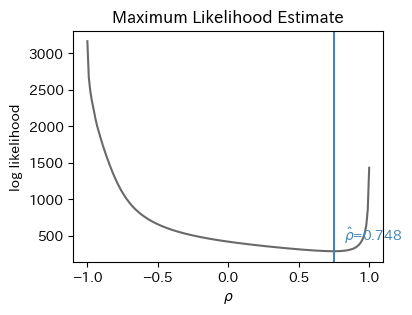

In [108]:
rho = 0.75
Cov = np.array([[1, rho], [rho, 1]])
X = multivariate_normal.rvs(mean=mean, cov=Cov, size=n, random_state=0)
df = pd.DataFrame(X, columns=["x", "y"])
df["y"], _ = pd.cut(df["y"], bins=3).factorize(sort=True)
polyserial_correlation(df["x"], df["y"])

## 点双列相関係数（point-biserial correlation）

**点双列相関係数** （point-biserial correlation） は 連続変数と自然な二値変数の間の相関を測るための相関係数。


:::{admonition} 点双列相関係数（point-biserial correlation）

連続変数 $X$ 、二値変数 $Y \in\{0,1\}$ に対して：

$$
r_{\text{pbi}}=\frac{\bar{X}_1-\bar{X}_0}{s_X} \cdot \sqrt{p q}
$$


用語：

- $\bar{X}_1, \bar{X}_0: Y=1, Y=0$ のときの $X$ の平均
- $s_X: X$ の標準偏差
- $p: Y=1$ の割合
- $q=1-p$

:::


どこで使われるのか？ → 例えば古典テスト理論では正答/誤答と全体の得点との相関を測るために使われる


:::{card} 参考文献

- [Lev, J. (1949). The point biserial coefficient of correlation. The Annals of Mathematical Statistics, 20(1), 125-126.](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-20/issue-1/The-Point-Biserial-Coefficient-of-Correlation/10.1214/aoms/1177730103.full)
- [Tate, R. F. (1954). Correlation between a discrete and a continuous variable. Point-biserial correlation. The Annals of mathematical statistics, 25(3), 603-607.](https://www.jstor.org/stable/2236844)
- [Kornbrot, D. (2014). Point biserial correlation. Wiley StatsRef: Statistics Reference Online.](https://onlinelibrary.wiley.com/doi/10.1002/9781118445112.stat06227)

:::

In [32]:
import numpy as np

def point_biserial_correlation(x: np.ndarray, y: np.ndarray) -> float:
    """
    Compute the point-biserial correlation between a continuous variable x
    and a binary variable y (0 or 1), assuming y is a true categorical variable.

    Parameters
    ----------
    x : np.ndarray
        Continuous variable.
    y : np.ndarray
        Binary variable (0 and 1), true categories.

    Returns
    -------
    float
        Point-biserial correlation coefficient.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    assert set(np.unique(y)).issubset({0, 1}), "y must be binary (0/1)"
    
    x1 = x[y == 1]
    x0 = x[y == 0]
    
    M1 = np.mean(x1)
    M0 = np.mean(x0)
    s = np.std(x, ddof=0)
    
    p = np.mean(y)
    q = 1 - p

    return (M1 - M0) / s * np.sqrt(p * q)


In [33]:
np.random.seed(0)
x = np.random.normal(size=100)
x_ = x + abs(x.min())
p = (x_ - x_.min()) / x_.max()
y = np.random.binomial(n=1, p=p, size=100)

point_biserial_correlation(x, y)

0.42540375845000344

`scipy.stats` にも実装がある

In [36]:
from scipy.stats import pointbiserialr
pointbiserialr(x, y)

SignificanceResult(statistic=0.4254037584500034, pvalue=1.0240154573107786e-05)

#### point-biserial と Pearsonの積率相関係数は等しい

In [37]:
from scipy.stats import pearsonr
pearsonr(x, y)

PearsonRResult(statistic=0.4254037584500034, pvalue=1.0240154573107786e-05)

## 双列相関係数（biserial correlation）

**バイシリアル相関係数** （biserial correlation, **双列相関係数**とも）  は、連続変数と人工的に二値化した変数（連続変数を閾値で分けたもの）の間の相関係数。

:::{admonition} 双列相関係数（biserial correlation）

連続変数 $X$ と 二値化変数 $Y \in\{0,1\}$ に対して：

$$
r_{\text{bi}}=\frac{\bar{X}_1-\bar{X}_0}{s_X} \cdot \frac{p q}{\phi(z)}
$$

各記号の意味：

- $\bar{X}_1, \bar{X}_0$ ：連続変数 $X$ の値のうち，$Y=1$ と $Y=0$ における平均
- $s_X$ ：連続変数 $X$ の全体の標準偏差
- $p, q: Y=1, Y=0$ の出現確率 $(p+q=1)$
- $z: Y=1$ に対応する潜在しきい値の標準正規分布におけるZ値（累積確率＝$p$）
- $\phi(z)$ ：標準正規分布の確率密度関数（PDF）

$$
\phi(z)=\frac{1}{\sqrt{2 \pi}} e^{-z^2 / 2}
$$
:::


仮定：

- $Y$ が自然なカテゴリ（二値）ではなく、連続変数を人工的にしきい値で切ったものという仮定が必要
- 連続変数 $X$ のほうは正規分布に近いことが望ましい
- カテゴリ変数が本当に二値カテゴリ（性別など）で、連続変数とは無関係に発生しているなら →  **点双列相関（point-biserial correlation）** を使うべき（数式は似てるが意味が異なる）


:::{card} 関連文献

- [Pearson, K. (1909). On a new method of determining correlation between a measured character A, and a character B, of which only the percentage of cases wherein B exceeds (or falls short of) a given intensity is recorded for each grade of A. Biometrika, 7(1/2), 96-105.](https://www.jstor.org/stable/2345365)
- [Jacobs, P., & Viechtbauer, W. (2017). Estimation of the biserial correlation and its sampling variance for use in meta‐analysis. Research synthesis methods, 8(2), 161-180.](https://pubmed.ncbi.nlm.nih.gov/27631635/)
:::


In [21]:
import numpy as np
from scipy.stats import norm

def biserial_correlation(x: np.ndarray, y: np.ndarray) -> float:
    """
    Compute the biserial correlation coefficient between a continuous variable x
    and a dichotomized variable y (0 or 1), assuming y was split from a latent normal variable.

    Parameters
    ----------
    x : np.ndarray
        Continuous variable.
    y : np.ndarray
        Dichotomous variable (0 and 1), assumed to be derived from a latent normal variable.

    Returns
    -------
    float
        Biserial correlation coefficient.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    assert set(np.unique(y)).issubset({0, 1}), "y must be binary (0/1)"
    
    x1 = x[y == 1]
    x0 = x[y == 0]
    M1 = np.mean(x1)
    M0 = np.mean(x0)
    s = np.std(x, ddof=1)

    p = np.mean(y)
    q = 1 - p
    z = norm.ppf(p)
    phi = norm.pdf(z)

    return (M1 - M0) / s * (p * q) / phi

In [22]:
rho = 0.05
cov = np.array([[1, rho], [rho, 1]])
X = multivariate_normal.rvs(cov=cov, size=100, random_state=0)
x = X[:, 0]
y = 1 * (X[:, 1] > 0.5)
biserial_correlation(x,  y)

0.06162599756903869

### biserialとpoint-biserialのイメージの違い

- biserialは人工的な二値変数が対象なので1つの連続値$y_{\text{latent}}$の分布をある閾値で切断したものを扱っている
- point-biserialは自然な二値変数なので2つのクラス$\{0, 1\}$の分布はそれぞれ分かれており、重なることもありうるイメージ。
    - 例えば潜在的な能力$y_{\text{latent}}$が高い人が正答する（$y=1$になる）確率は高いが、100％ではなく偶然誤答することもありうる

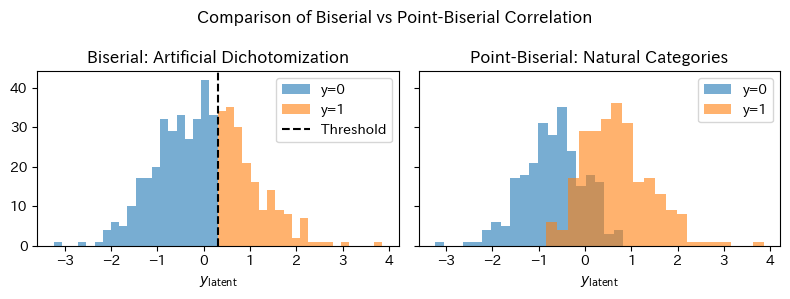

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
np.random.seed(42)
n = 500
x = np.random.normal(loc=0, scale=1, size=n)
threshold = 0.3
y_biserial = (x > threshold).astype(int)
y_point = (x + np.random.normal(0, 0.5, n) > 0).astype(int)

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

axs[0].hist(x[y_biserial == 0], bins=20, alpha=0.6, label="y=0")
axs[0].hist(x[y_biserial == 1], bins=20, alpha=0.6, label="y=1")
axs[0].axvline(threshold, color='k', linestyle='--', label='Threshold')
axs[0].set_title("Biserial: Artificial Dichotomization")
axs[0].set_xlabel(r"$y_{\text{latent}}$")
axs[0].legend()

axs[1].hist(x[y_point == 0], bins=20, alpha=0.6, label="y=0")
axs[1].hist(x[y_point == 1], bins=20, alpha=0.6, label="y=1")
axs[1].set_title("Point-Biserial: Natural Categories")
axs[1].set_xlabel(r"$y_{\text{latent}}$")
axs[1].legend()

plt.suptitle("Comparison of Biserial vs Point-Biserial Correlation")
plt.tight_layout()
plt.show()

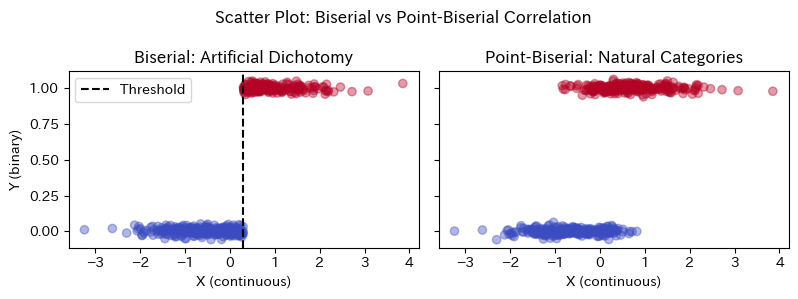

In [28]:
# Create scatter plots with color-coded categories for better intuition
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Biserial: artificial thresholding
axs[0].scatter(x, y_biserial + np.random.normal(0, 0.02, size=n), alpha=0.4, c=y_biserial, cmap='coolwarm')
axs[0].axvline(threshold, color='k', linestyle='--', label='Threshold')
axs[0].set_title("Biserial: Artificial Dichotomy")
axs[0].set_xlabel("X (continuous)")
axs[0].set_ylabel("Y (binary)")
axs[0].legend()

# Point-biserial: natural binary
axs[1].scatter(x, y_point + np.random.normal(0, 0.02, size=n), alpha=0.4, c=y_point, cmap='coolwarm')
axs[1].set_title("Point-Biserial: Natural Categories")
axs[1].set_xlabel("X (continuous)")

plt.suptitle("Scatter Plot: Biserial vs Point-Biserial Correlation")
plt.tight_layout()
plt.show()


#### Point-Biserialに補正係数をかけたのがBiserial

point-biserial

$$
r_{\text{pbi}}=\frac{\bar{X}_1-\bar{X}_0}{s_X} \cdot \sqrt{p q}
$$

に対して補正係数$\frac{\sqrt{pq}}{\phi(z)}$をかけたのがBiserial

$$
r_{\text{bi}} = r_{\text{pbi}} \cdot \frac{\sqrt{pq}}{\phi(z)} = \frac{\bar{X}_1-\bar{X}_0}{s_X} \cdot \frac{p q}{\phi(z)}
$$


In [40]:
rho = 0.5
cov = np.array([[1, rho], [rho, 1]])
X = multivariate_normal.rvs(cov=cov, size=100, random_state=0)
x = X[:, 0]
y = 1 * (X[:, 1] > 0.5)
print(f"biserial: {biserial_correlation(x, y):.5f}")
print(f"point_biserial: {point_biserial_correlation(x, y):.5f}")

biserial: 0.42521
point_biserial: 0.32762


In [41]:
from semopy.polycorr import polyserial_corr
polyserial_corr(x, y)

0.4575579360276353

### biserialとpoint-biserialはどれくらい差が出るのか

[MacCallum, R. C., Zhang, S., Preacher, K. J., & Rucker, D. D. (2002). On the practice of dichotomization of quantitative variables. Psychological methods, 7(1), 19.](https://pubmed.ncbi.nlm.nih.gov/11928888/)



## スピアマンの順位相関係数（Spearman's rho）

順序尺度 × 順序尺度 あるいは 任意の変数を順位に置き換えて測る相関（順位ベースのピアソン相関）

線形性や正規生の仮定を必要としない


2つの変数$X, Y$の$n$個の観測値の各ペア$(x_i, y_i)$の順位の差$d_i$を求め

$$
\rho=1-\frac{6 \sum d_i^2}{n\left(n^2-1\right)}
$$

In [60]:
x = [1, 1, 2, 2, 3, 3]
y = [0, 0, 0, 1, 1, 1]

from scipy.stats import spearmanr
print(f"{spearmanr(x, y).statistic=:.3f}")

from ordinalcorr import polychoric
print(f"{polychoric(x, y)=:.3f}")

spearmanr(x, y).statistic=0.816
polychoric(x, y)=0.999


## ケンドールの順位相関係数（Kendall's tau）

順序尺度 × 順序尺度（ランキング）に対して使われる相関指標で、順位の一致/不一致ペア数に基づいて計算される

[kendalltau — SciPy v1.15.2 Manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy.stats.kendalltau)

$$
\tau=\frac{n_c-n_d}{\sqrt{\left(n_0-n_1\right)\left(n_0-n_2\right)}}
$$

- $n_c$ ：一致順（concordant）のペアの数
- $n_d$ ：不一致順（discordant）のペアの数
- $n_0=\frac{n(n-1)}{2}:$ すべてのペアの総数
- $n_1=\sum t_i\left(t_i-1\right) / 2$ ：Xで順位が同じぺアの数の補正（ties in X）
- $n_2=\sum u_j\left(u_j-1\right) / 2$ ：Yで順位が同じぺアの数の補正（ties in Y）

In [59]:
x = [1, 1, 2, 2, 3, 3]
y = [0, 0, 0, 1, 1, 1]

from scipy.stats import kendalltau
print(f"{kendalltau(x, y).statistic=:.3f}")

from ordinalcorr import polychoric
print(f"{polychoric(x, y)=:.3f}")

kendalltau(x, y).statistic=0.770
polychoric(x, y)=0.999


## 比較

2変量の標準正規分布からランダムにデータを生成し、`pandas.cut()`で離散化したデータをもとに相関係数を計算して比較する

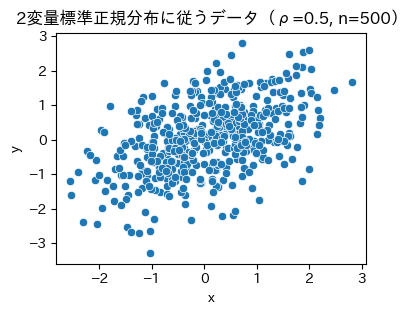

In [155]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, pearsonr, spearmanr, kendalltau

def gen_bivariate_normal(rho=0.5, size=1000):
    # 2変量標準正規分布によるデータ生成
    mean = [0, 0]
    std = [1, 1]
    cov = rho * std[0] * std[1]
    Cov = np.array([[std[0] ** 2, cov], [cov, std[1] ** 2]])
    X = multivariate_normal.rvs(mean=mean, cov=Cov, size=size, random_state=0)
    df = pd.DataFrame(X, columns=["x", "y"])
    return df


# データ生成
n = 500
rho = 0.5
continuous_data = gen_bivariate_normal(rho=rho, size=n)

# データをグラフにplot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_fontja

fig, ax = plt.subplots(figsize=[4, 3])

# 元データ
sns.scatterplot(data=continuous_data, x="x", y="y", ax=ax)
ax.set(title=f"2変量標準正規分布に従うデータ（ρ={rho}, n={n}）")
fig.show()

### 連続変数 x 離散変数

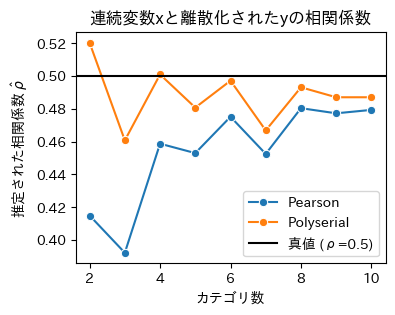

In [158]:
from ordinalcorr import polyserial

# 離散化のカテゴリ数を変えつつ相関係数を算出
results = []
for k in range(2, 11):
    x = continuous_data["x"]
    y, _ = pd.cut(continuous_data["y"], bins=k).factorize(sort=True)
    results += [
        dict(method="Pearson", value=pearsonr(x, y).statistic, k=k),
        dict(method="Polyserial", value=polyserial(x, y), k=k),
    ]
results = pd.DataFrame(results)

# データをグラフにplot
fig, ax = plt.subplots(figsize=[4, 3])
sns.lineplot(x="k", y="value", data=results, hue="method", marker="o", ax=ax)
ax.axhline(rho, label=f"真値 (ρ={rho})", color="black")
ax.set(
    xlabel="カテゴリ数",
    ylabel=r"推定された相関係数 $\hat{\rho}$",
    title="連続変数xと離散化されたyの相関係数"
)
ax.legend()
fig.show()

### 離散変数 x 離散変数

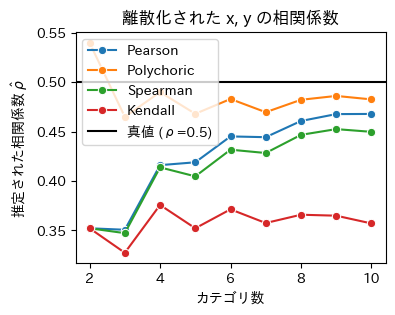

In [157]:
from ordinalcorr import polychoric

# 離散化のカテゴリ数を変えつつ相関係数を算出
results = []
for k in range(2, 11):
    x, _ = pd.cut(continuous_data["x"], bins=k).factorize(sort=True)
    y, _ = pd.cut(continuous_data["y"], bins=k).factorize(sort=True)
    results += [
        dict(method="Pearson", value=pearsonr(x, y).statistic, k=k),
        dict(method="Polychoric", value=polychoric(x, y), k=k),
        dict(method="Spearman", value=spearmanr(x, y).statistic, k=k),
        dict(method="Kendall", value=kendalltau(x, y).statistic, k=k),
    ]
results = pd.DataFrame(results)

# データをグラフにplot
fig, ax = plt.subplots(figsize=[4, 3])
sns.lineplot(x="k", y="value", data=results, hue="method", marker="o", ax=ax)
ax.axhline(rho, label=f"真値 (ρ={rho})", color="black")
ax.set(
    xlabel="カテゴリ数",
    ylabel=r"推定された相関係数 $\hat{\rho}$",
    title="離散化された x, y の相関係数"
)
ax.legend()
fig.show()

In [123]:
# NOTE: データ生成時はfactorizeを使う場合は注意
k = 3
x = pd.Series([3, 4, 1, 2, 5])
x1 = pd.cut(x, bins=k, labels=range(k)).astype(int).to_list()
x2, _ = pd.cut(x, bins=k).factorize(sort=True)
x3, _ = pd.cut(x, bins=k).factorize(sort=False)
print(f"""
{x1=}
{x2=}
{x3=}
""")


x1=[1, 2, 0, 0, 2]
x2=array([1, 2, 0, 0, 2])
x3=array([0, 1, 2, 2, 1])



## 参考文献

- 豊田秀樹（2012）『因子分析入門』、東京図書。
- [小杉考司（2013）順序尺度の相関係数（ポリコリック相関係数）について](http://kosugitti.sakura.ne.jp/wp/wp-content/uploads/2013/08/polynote.pdf)
- [萩生田伸子, & 繁桝算男. (1996). 順序付きカテゴリカルデータへの因子分析の適用に関するいくつかの注意点. 心理学研究, 67(1), 1-8.](https://www.jstage.jst.go.jp/article/jjpsy1926/67/1/67_1_1/_article/-char/ja/)
- [Rのpsychパッケージのマニュアル](https://personality-project.org/r/psych-manual.pdf#page=408.70) p.411あたりのtetrachoricのDetailsセクションの説明が詳しい